In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Load and Filter Data

In [2]:
ds_orig = pd.read_csv('yellow_tripdata_2016-06.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [3]:
ds = pd.read_csv('yellow_tripdata_2016-06.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],
                      usecols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'fare_amount', 'tip_amount'])

In [4]:
ds = ds.loc[(ds['tpep_pickup_datetime'] < datetime(2016,6,13)) & (ds['tpep_pickup_datetime'] >= datetime(2016,6,6))]

In [5]:
ds['trip_time'] = ds['tpep_dropoff_datetime'] - ds['tpep_pickup_datetime']

In [6]:
geometry = [Point(xy) for xy in zip(ds['pickup_longitude'], ds['pickup_latitude'])]

In [7]:
ds = ds.drop(['tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude'], axis = 1)

In [8]:
gds = gpd.read_file('Borough Boundaries.geojson')

In [9]:
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(ds.index.values, crs = crs, geometry = geometry)

In [10]:
manhattan = gpd.GeoDataFrame([True], crs = crs, geometry = [gds.iloc[0].loc['geometry']])

In [11]:
print(datetime.now())
gdf2 = gpd.sjoin(gdf, manhattan, how = 'left')
print(datetime.now())

2019-04-04 23:41:27.576093
2019-04-04 23:47:22.731674


In [12]:
ds = ds.join(gdf2.set_index('0_left')['0_right'], how = 'left')

In [13]:
ds = ds[ds['0_right']  == True].drop('0_right', axis = 1)

# Clean Data

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
ds.isnull().sum()

tpep_pickup_datetime    0
passenger_count         0
fare_amount             0
tip_amount              0
trip_time               0
dtype: int64

/home/tselab/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


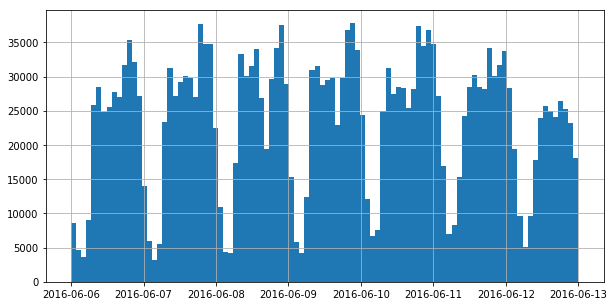

In [17]:
ds['tpep_pickup_datetime'].hist(bins = 100, figsize = (10, 5))

In [ ]:
ds.describe()

In [18]:
# delete samples with negative fare and fare lower than the initial fare $2.5
ds = ds[ds.fare_amount >= 2.5]

In [19]:
# delete samples with <10 min trip time and >$200 fare
ds = ds[~((ds.fare_amount > 200) & (ds.trip_time < timedelta(minutes = 10)))]

In [20]:
# delete negative tip_amount
ds = ds[ds['tip_amount'] >= 0]

In [21]:
# delete negative trip time
ds = ds[ds.trip_time > timedelta(minutes = 0)]

In [22]:
# delete trip within 1 min and with a fare > $5
ds = ds[~((ds.trip_time < timedelta(minutes = 1)) & (ds.fare_amount > 5))]

In [23]:
# delete trip with 1+ hour but only make < $100, unrealistic
ds = ds[~((ds.trip_time > timedelta(hours = 1)) & (ds.fare_amount < 100))]

In [24]:
# even if the vehicle is stopped, the driver should be able to earn $2.5 + $.5 * minutes
# delete all trips with fares below this function
basefair = ds['trip_time'].dt.seconds//60 * .5 + 2.5
ds = ds[ds['fare_amount'] >= basefair]

In [25]:
ds.describe()

,passenger_count,fare_amount,tip_amount,trip_time
count,2.341996e+06,2.341996e+06,2.341996e+06,2341996
mean,1.655292e+00,1.173836e+01,1.629182e+00,0 days 00:13:31.485701
std,1.301244e+00,8.329178e+00,2.077298e+00,0 days 00:09:24.726961
min,0.000000e+00,2.500000e+00,0.000000e+00,0 days 00:00:01
25%,1.000000e+00,6.500000e+00,0.000000e+00,0 days 00:06:44
50%,1.000000e+00,9.500000e+00,1.320000e+00,0 days 00:11:08
75%,2.000000e+00,1.400000e+01,2.340000e+00,0 days 00:17:48
max,8.000000e+00,4.900000e+02,3.000000e+02,0 days 05:15:00


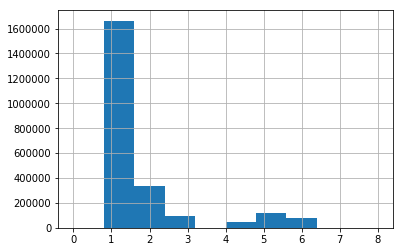

In [26]:
ds.passenger_count.hist()

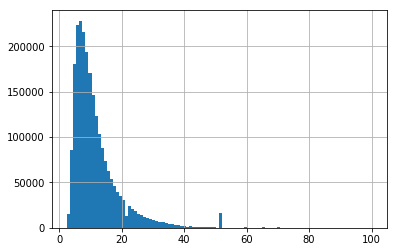

In [27]:
ds.fare_amount[ds.fare_amount<100].hist(bins = 100)

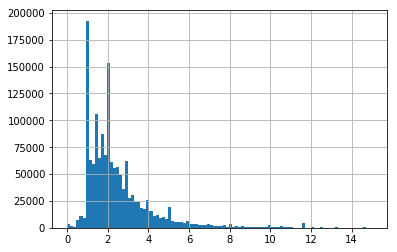

In [28]:
ds.tip_amount[(ds.tip_amount < 15) & (ds.tip_amount > 0)].hist(bins = 100)

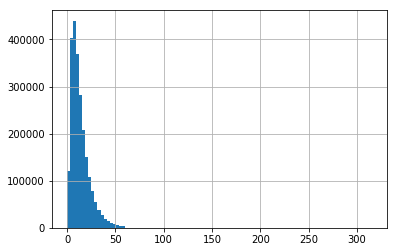

In [29]:
(ds.trip_time.dt.seconds/60).hist(bins = 100)

In [30]:
ds_extra = ds_orig.loc[ds.index]

In [32]:
# delete trips with 0 trip_distance
ds = ds[ds_extra['trip_distance'] > 0]

In [35]:
ds_extra = ds_orig.loc[ds.index]
ds['speed'] = ds_extra['trip_distance']/(ds['trip_time'].dt.seconds/3600)

In [44]:
# highest speed limit in Manhattan is 50 mph
# delete trips with speed > 70 mph
ds = ds[ds['speed'] < 70]

In [100]:
# clean by dropoff location
# should be within (-74.82, -73.4), (40.15, 41.1)
ds_extra = ds_orig.loc[ds.index]

In [104]:
ds = ds[(ds_extra['dropoff_longitude'] > -74.82) & (ds_extra['dropoff_longitude'] < -73.4)
& (ds_extra['dropoff_latitude'] > 40.15) & (ds_extra['dropoff_latitude'] < 41.1)]

# Calculate Metric

In [46]:
def cal_effi(ds):
    return ((ds['fare_amount'] + ds['tip_amount']) * ds['passenger_count'] / (ds['trip_time'].dt.seconds/60)).mean()

In [47]:
efficiency = cal_effi(ds)
print(efficiency)

1.8225284271104185


# Validating the metric with different sample sizes

In [48]:
# draw different fractions of samples, each fraction for 1000 times, calculate the metric
fracs = [.25, .5, .75]
nperm = 1000
exp = np.full((nperm, 3), np.nan)
for iperm in range(nperm):
    for ifrac in range(len(fracs)):
        dsf = ds.sample(frac = fracs[ifrac], random_state = iperm)
        exp[iperm, ifrac] = cal_effi(dsf)

In [49]:
expdf = pd.DataFrame(exp, columns = ['25%', '50%', '75%'])

In [50]:
import seaborn as sns

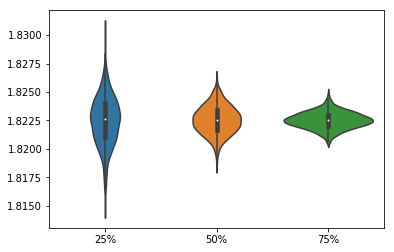

In [51]:
ax = sns.violinplot(data = expdf)
# seems to be pretty stable

# Speed test for different sample sizes (Practical complexity)

In [ ]:
import timeit
sizes = [2**exp for exp in range(8, 23)]
res = []
ntest = 5000
for s in sizes:
    dsp = ds.sample(n = s, random_state = 0, replace = True)
    t = timeit.timeit('cal_effi(dsp)', number = ntest, globals = globals())
    res.append(t)

In [ ]:
test = pd.DataFrame({'nsamples': sizes, 'time_5000': res})

In [ ]:
test

In [ ]:
import scipy.stats
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(test['nsamples'], test['time_5000']/ntest)

In [ ]:
x = np.linspace(min(sizes), max(sizes), 5000)

In [ ]:
y = x*slope + intercept

In [ ]:
plt.plot(test['nsamples'], test['time_5000']/ntest, '*')
plt.plot(x, y, '-')
plt.xscale('log')

In [ ]:
r_value**2

# Visualization

In [105]:
# time of the day aggregated
ds['hour'] = ds['tpep_pickup_datetime'].dt.hour+1

/home/tselab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
eff_hour = ds.groupby('hour').apply(cal_effi)

Text(0.5, 1.0, 'efficiency by hour')

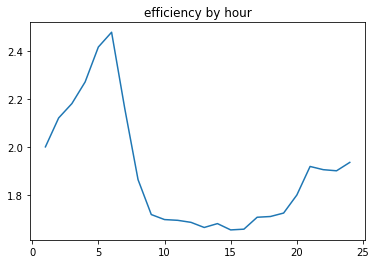

In [108]:
plt.plot(eff_hour)
plt.title('efficiency by hour')

Text(0.5, 1.0, '#trips by hour')

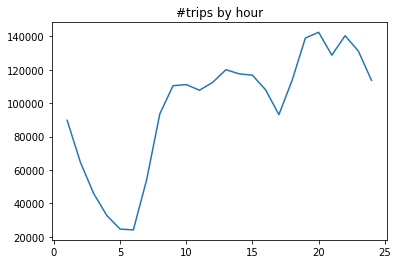

In [109]:
# count of trips
plt.plot(ds.groupby('hour')['hour'].count())
plt.title('#trips by hour')

In [110]:
# total fare
ds['tot'] = ds['fare_amount'] + ds['tip_amount']

/home/tselab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'mean trip $ by hour')

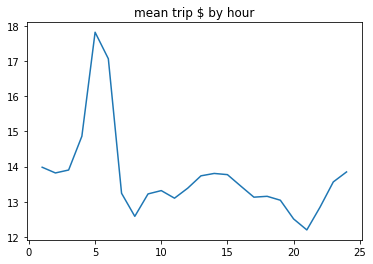

In [111]:
plt.plot(ds.groupby('hour')['tot'].mean())
plt.title('mean trip $ by hour')

In [58]:
ds['trip_time_minute'] = ds['trip_time'].dt.seconds/60

Text(0.5, 1.0, 'mean trip minute by hour')

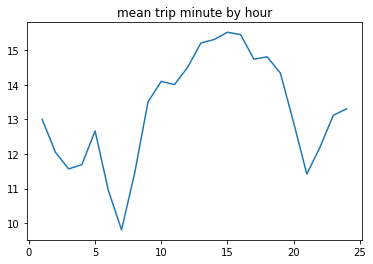

In [112]:
plt.plot(ds.groupby('hour')['trip_time_minute'].mean())
plt.title('mean trip minute by hour')
# wow! People are driving longer time but make less money!

In [60]:
ds_extra = ds_orig.loc[ds.index]

In [61]:
ds['speed'] = ds_extra['trip_distance']/(ds['trip_time'].dt.seconds/3600)

Text(0.5, 1.0, 'trip speed (mph)')

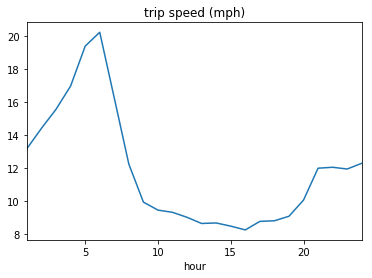

In [113]:
ds.groupby('hour')['speed'].mean().plot()
plt.title('trip speed (mph)')

Text(0.5, 1.0, '# of passengers per trip')

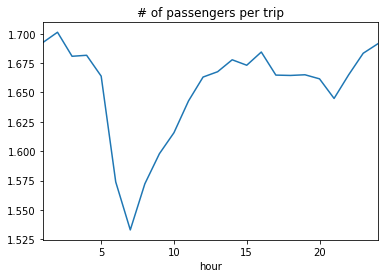

In [114]:
ds.groupby('hour')['passenger_count'].mean().plot()
plt.title('# of passengers per trip')

In [64]:
# day of the week aggregated
ds['dow'] = ds['tpep_pickup_datetime'].dt.dayofweek

In [65]:
eff_dow = ds.groupby('dow').apply(cal_effi)

Text(0.5, 1.0, 'efficiency by day of week')

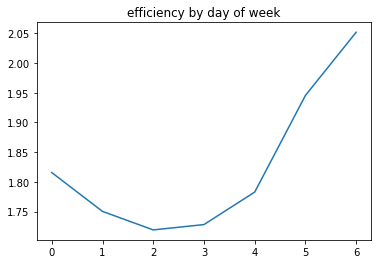

In [115]:
plt.plot(eff_dow)
plt.title('efficiency by day of week')

Text(0.5, 1.0, '#trips by day of week')

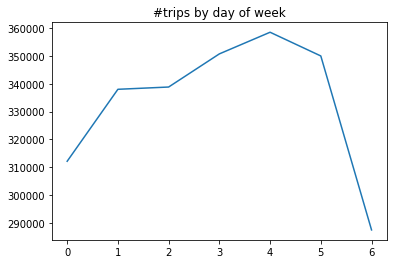

In [116]:
# count of trips
plt.plot(ds.groupby('dow')['dow'].count())
plt.title('#trips by day of week')

Text(0.5, 1.0, 'efficiency across the week')

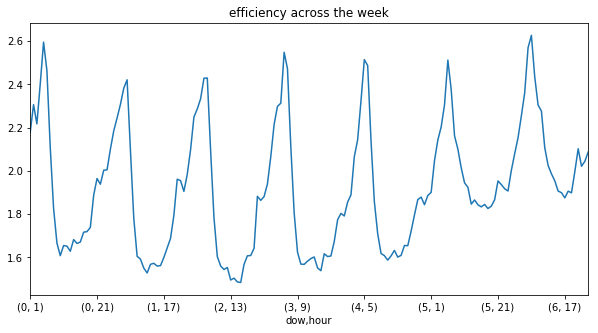

In [117]:
# day & time
effi_day_hour = ds.groupby(['dow', 'hour']).apply(cal_effi)
effi_day_hour.plot(figsize = (10,5))
plt.title('efficiency across the week')

In [118]:
dow_by_hour = effi_day_hour.unstack(level = 1)

Text(0.5, 1.0, 'efficiency across the week')

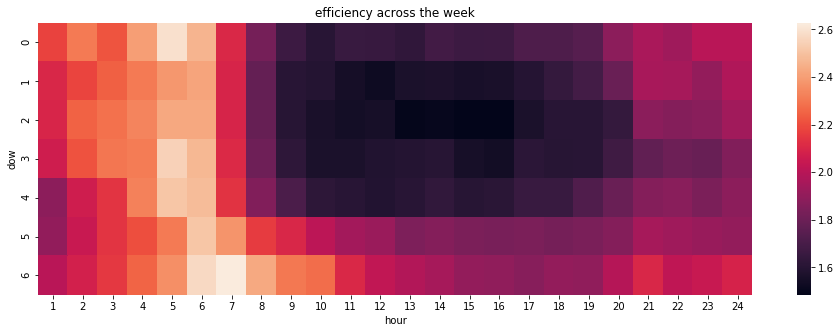

In [119]:
plt.figure(figsize=(16, 5))
ax = sns.heatmap(dow_by_hour)
plt.title('efficiency across the week')

Text(0.5, 1.0, 'speed(mph) across the week')

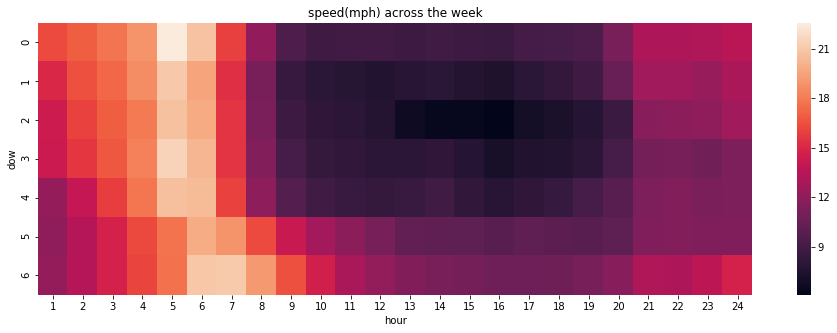

In [120]:
speed = ds.groupby(['dow', 'hour'])['speed'].mean().unstack(level = 1)
plt.figure(figsize=(16, 5))
ax = sns.heatmap(speed)
plt.title('speed(mph) across the week')

Text(0.5, 1.0, 'mean trip duration across the week')

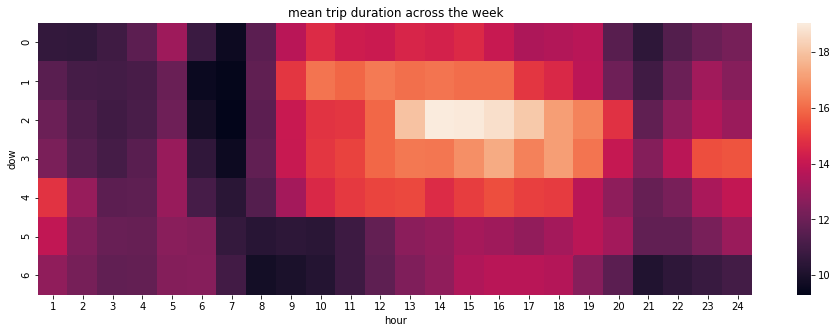

In [121]:
trip_time = ds.groupby(['dow', 'hour'])['trip_time_minute'].mean().unstack(level = 1)
plt.figure(figsize=(16, 5))
ax = sns.heatmap(trip_time)
plt.title('mean trip duration across the week')

In [122]:
ds['distance'] = ds_extra['trip_distance']

/home/tselab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'mean trip distance across the week')

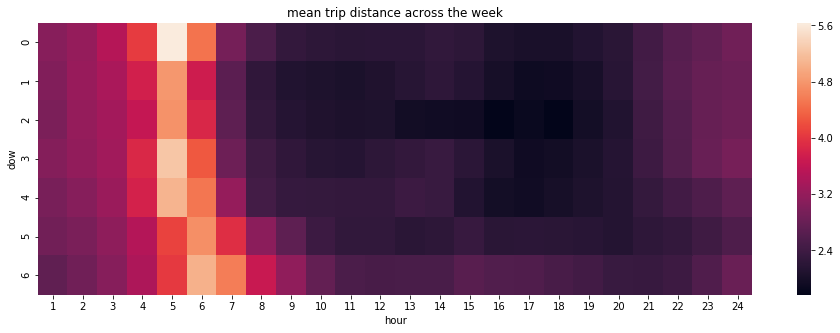

In [123]:
distance = ds.groupby(['dow', 'hour'])['distance'].mean().unstack(level = 1)
plt.figure(figsize=(16, 5))
ax = sns.heatmap(distance)
plt.title('mean trip distance across the week')

In [132]:
ds['efficiency'] = (ds['fare_amount'] + ds['tip_amount']) * ds['passenger_count'] / (ds['trip_time'].dt.seconds/60)

/home/tselab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [230]:
# why high efficiency?
ds_extra = ds_orig.loc[ds.index]
sample05 = ds_extra[(ds['dow'] == 0) & (ds['hour'] == 5)]

In [231]:
sample05[['dropoff_longitude', 'dropoff_latitude']].describe()

,dropoff_longitude,dropoff_latitude
count,2178.000000,2178.000000
mean,-73.946215,40.747250
std,0.071604,0.046396
min,-74.183319,40.578369
25%,-73.988436,40.722909
50%,-73.963608,40.755054
75%,-73.909954,40.773776
max,-73.730911,40.919746


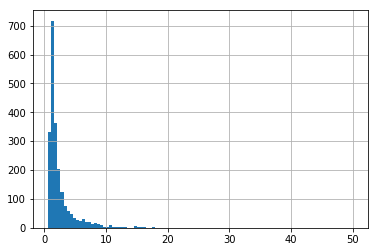

In [232]:
ds.loc[sample05.index]['efficiency'].hist(bins = 100)

In [233]:
highe = ds.loc[sample05.index]['efficiency'] > 5

In [234]:
# trips to airport?
geometry = [Point(xy) for xy in zip(sample05.loc[highe]['dropoff_longitude'], sample05.loc[highe]['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample05.loc[highe].index.values, crs = crs, geometry = geometry)

In [235]:
gds = gpd.read_file('Borough Boundaries.geojson')

Text(0.5, 1.0, 'destination for high efficiency trips (e>5, n=231)')

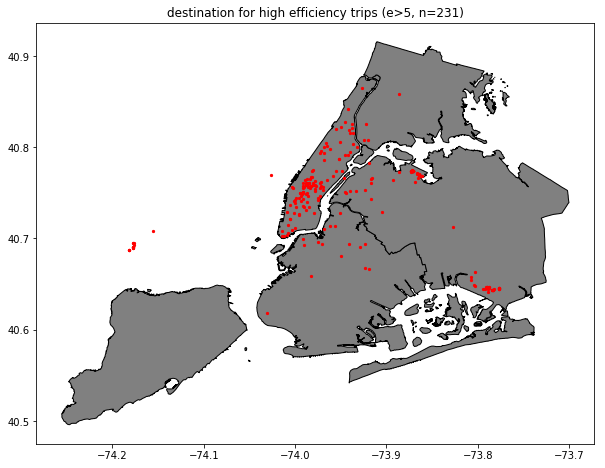

In [236]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('destination for high efficiency trips (e>5, n=231)')

In [156]:
longdist = sample05['trip_distance'] > 10

In [163]:
geometry = [Point(xy) for xy in zip(sample05.loc[longdist]['dropoff_longitude'], sample05.loc[longdist]['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample05.loc[longdist].index.values, crs = crs, geometry = geometry)

Text(0.5, 1.0, 'destination for long distance trips (dis > 10mi)')

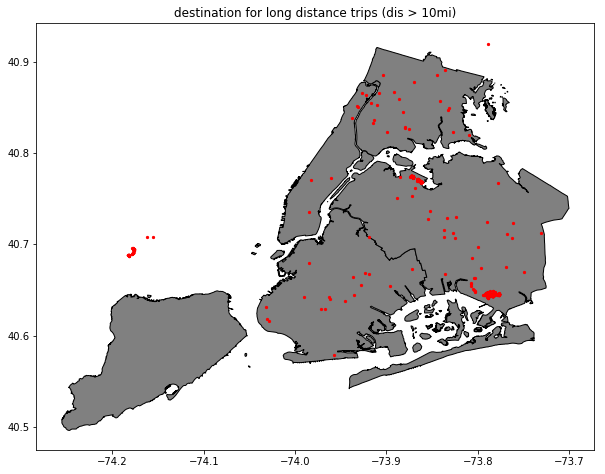

In [164]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('destination for long distance trips (dis > 10mi)')

In [184]:
geometry = [Point(xy) for xy in zip(sample05['dropoff_longitude'], sample05['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample05.index.values, crs = crs, geometry = geometry)

Text(0.5, 1.0, 'all destinations for the high efficiency sample (n = 2178)')

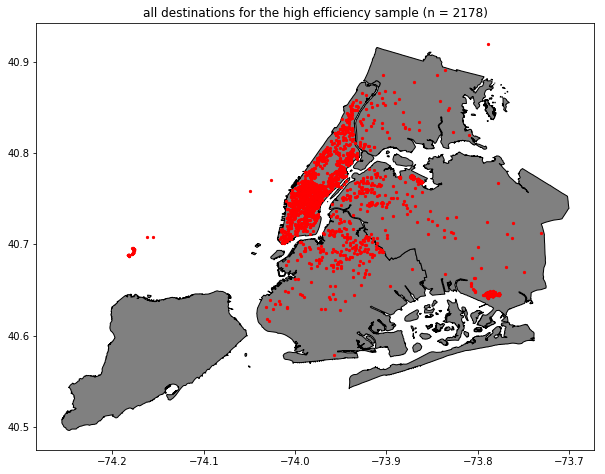

In [185]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('all destinations for the high efficiency sample (n = 2178)')

In [168]:
ds_extra = ds_orig.loc[ds.index]
sample216 = ds_extra[(ds['dow'] == 2) & (ds['hour'] == 16)]

In [178]:
sample216.shape

(13244, 19)

In [179]:
geometry = [Point(xy) for xy in zip(sample216['dropoff_longitude'], sample216['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample216.index.values, crs = crs, geometry = geometry)

Text(0.5, 1.0, 'all destinations for the low efficiency sample (n = 13244)')

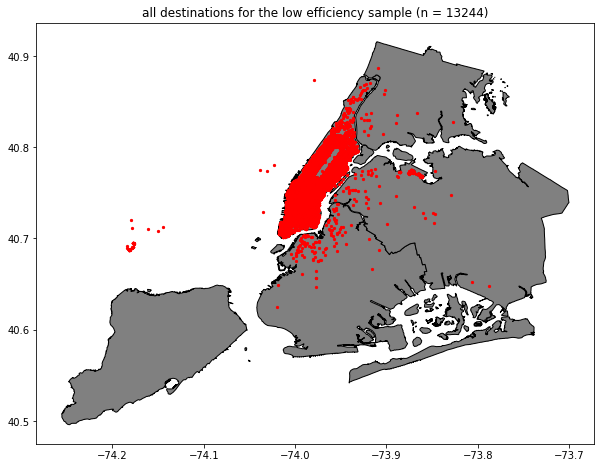

In [180]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('all destinations for the low efficiency sample (n = 13244)')

In [226]:
highe = ds.loc[sample216.index]['efficiency'] > 5

In [216]:
geometry = [Point(xy) for xy in zip(sample216.loc[highe]['dropoff_longitude'], sample216.loc[highe]['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample216.loc[highe].index.values, crs = crs, geometry = geometry)

Text(0.5, 1.0, 'destination for high efficiency trips (e>5, n=388)')

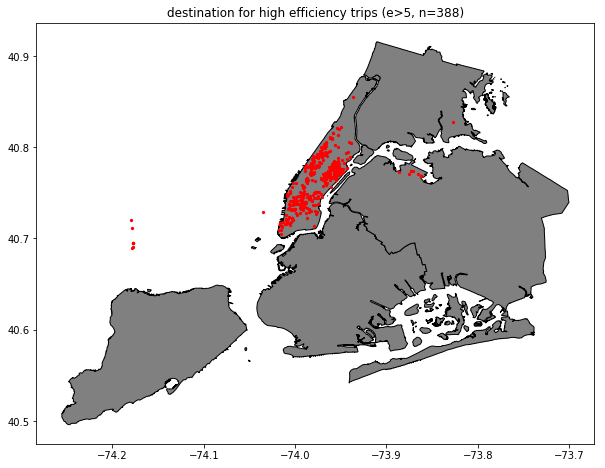

In [219]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('destination for high efficiency trips (e>5, n=388)')

In [181]:
sample66 = ds_extra[(ds['dow'] == 6) & (ds['hour'] == 6)]
geometry = [Point(xy) for xy in zip(sample66['dropoff_longitude'], sample66['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample66.index.values, crs = crs, geometry = geometry)

In [182]:
sample66.shape

(2964, 19)

Text(0.5, 1.0, 'all destinations for the high efficiency sample (n = 2964)')

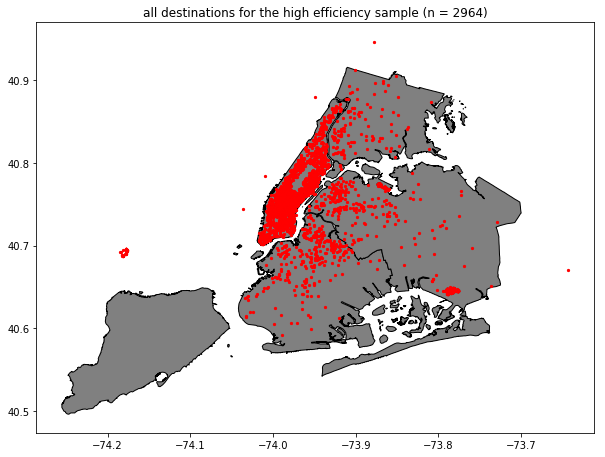

In [183]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('all destinations for the high efficiency sample (n = 2964)')

In [187]:
sample417 = ds_extra[(ds['dow'] == 4) & (ds['hour'] == 17)]
geometry = [Point(xy) for xy in zip(sample417['dropoff_longitude'], sample417['dropoff_latitude'])]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(sample417.index.values, crs = crs, geometry = geometry)

In [188]:
sample417.shape

(12641, 19)

Text(0.5, 1.0, 'all destinations for the low efficiency sample (n = 12641)')

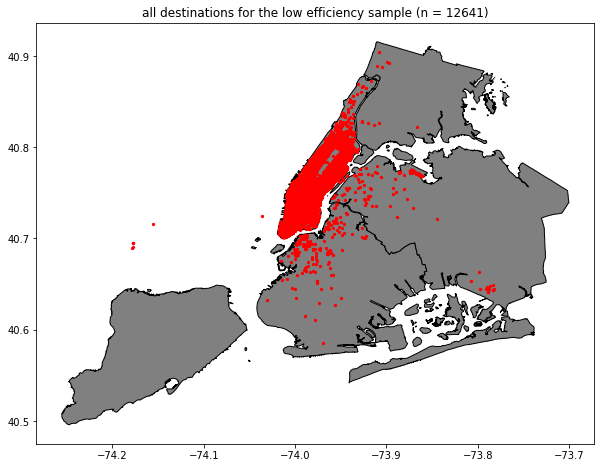

In [189]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')
gds.plot(ax = ax, color = 'gray', edgecolor='black')
gdf.plot(ax = ax, marker = 'o', color = 'red', markersize=5)
plt.title('all destinations for the low efficiency sample (n = 12641)')

In [237]:
hisample = ds[(ds['dow'] == 0) & (ds['hour'] == 5)]
losample = ds[(ds['dow'] == 2) & (ds['hour'] == 16)]

In [264]:
(hisample['efficiency']>5).sum()

231

In [263]:
(losample['efficiency']>5).sum()

388

Text(0.5, 1.0, 'Spread of trip time for high/low efficiency samples (y-axis in proprotion)')

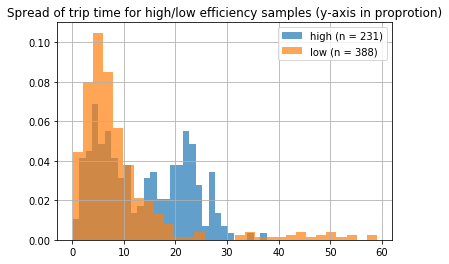

In [266]:
fig = plt.figure()
ax = fig.add_subplot()
hisample[hisample['efficiency']>5]['trip_time_minute'].hist(ax = ax, bins = 30, density = True, alpha = .7, label = 'high (n = 231)')
losample[losample['efficiency']>5]['trip_time_minute'].hist(ax = ax, bins = 30, density = True, alpha = .7, label = 'low (n = 388)')
plt.legend()
plt.title('Spread of trip time for high/low efficiency samples (y-axis in proprotion)')